In [2]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ", device)


Using:  cuda


In [4]:
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)
print(train_dataset)

test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor()
)
print(test_dataset)

batch_size = 100
n_epochs = 20


C:\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)

# valid_loader = torch.utils.data.DataLoader(
#     dataset=valid_dataset, batch_size=batch_size, shuffle=False
# )

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)


# RNN Model

In [64]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super().__init__()

        # ? Hidden layer dimentions
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # ? shape: (batch, seq, feature)
        self.rnn = nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True)

        # ? Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # ? x shape: (batch_size, seq_len, input_size)
        # ? h0 shape: (n_layers, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        h0 = h0.to(device)

        # ? out shape: (seq_len, batch_size, hidden_dim) => (64, 28, 100)
        # ? hn shape: (n_layers * num_directions, batch_size, hidden_dim)
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])

        return out


# LSTM Model

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        c0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        h0, c0 = h0.to(device), c0.to(device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


# GRU Model

In [54]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout=0.2):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_dim))
        h0 = h0.to(device)

        out, hn = self.gru(x, h0)
        out = self.fc(out[:, -1, :])

        return out


# coRNN Model

In [60]:
class coRNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, dt, gamma, epsilon):
        super().__init__()

        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon

        self.i2h = nn.Linear(input_dim + hidden_dim + hidden_dim, hidden_dim)

    def forward(self, x, hy, hz):
        x, hy, hz = x.to(device), hy.to(device), hz.to(device)
        
        combined_layer = torch.cat((x, hz, hy), 1)
        hz = hz + self.dt * (
            torch.tanh(self.i2h(combined_layer)) - self.gamma * hy - self.epsilon * hz
        )
        hy = hy + self.dt * hz

        return hy, hz


class coRNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dt, gamma, epsilon):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.n_layer = n_layers

        self.cornn = coRNNCell(input_dim, hidden_dim, dt, gamma, epsilon)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        hy = Variable(torch.zeros(x.size(0), self.hidden_dim))
        hz = Variable(torch.zeros(x.size(0), self.hidden_dim))
        hy, hz = hy.to(device), hz.to(device)

        for t in range(x.size(1)):
            hy, hz = self.cornn(x[:, t, :], hy, hz)

        out = self.fc(hy)

        return out


In [9]:
input_dim = 28
hidden_dim = 100
output_dim = 10
n_layers = 3

seq_dim = 28


In [43]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.view(-1, seq_dim, input_dim)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # ? Forward pass
        # * outputs size = (100, 10)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # ? Backward and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(train_loader)


def validate(model, valid_loader):
    model.eval()
    correct, total = 0, 0

    for images, labels in valid_loader:
        images = images.view(-1, seq_dim, input_dim).to(device)

        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()

    accuracy = 100 * correct / total
    
    return accuracy

def predict(model, image):
    model.eval()
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)

    return predicted


# Training RNN

In [66]:
rnn_model = RNNModel(input_dim, hidden_dim, output_dim, n_layers)
rnn_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = optim.SGD(rnn_model.parameters(), lr=learning_rate)  
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [67]:
rnn_valid_accuracy = []
rnn_train_loss = []

for epoch in range(n_epochs):
    loss = train(rnn_model, train_loader, optimizer, criterion)
    rnn_train_loss.append(loss)

    accuracy = validate(rnn_model, test_loader)
    rnn_valid_accuracy.append(accuracy)

    print(f"epoch: {epoch+1}, training-loss: {loss}, validation-accuracy: {accuracy}")


epoch: 1, training-loss: 1.0073960847159227, validation-accuracy: 87.87000274658203
epoch: 2, training-loss: 0.3928817892447114, validation-accuracy: 93.02999877929688
epoch: 3, training-loss: 0.22702359613652032, validation-accuracy: 95.41000366210938
epoch: 4, training-loss: 0.18066476112852495, validation-accuracy: 95.41000366210938
epoch: 5, training-loss: 0.14883647488740584, validation-accuracy: 96.0199966430664
epoch: 6, training-loss: 0.11993418326135724, validation-accuracy: 97.06999969482422
epoch: 7, training-loss: 0.10349659633046637, validation-accuracy: 96.8499984741211
epoch: 8, training-loss: 0.09791822106267015, validation-accuracy: 97.48999786376953
epoch: 9, training-loss: 0.08511939519861092, validation-accuracy: 97.73999786376953
epoch: 10, training-loss: 0.08340918095239128, validation-accuracy: 97.55000305175781
epoch: 11, training-loss: 0.0738005598859551, validation-accuracy: 97.80999755859375
epoch: 12, training-loss: 0.06654157261596992, validation-accuracy: 

# Training LSTM

In [17]:
lstm_model = LSTMModel(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = optim.SGD(lstm_model.parameters(), lr=learning_rate)  


In [18]:
lstm_valid_accuracy = []
lstm_train_loss = []

for epoch in range(n_epochs):
    loss = train(lstm_model, train_loader, optimizer, criterion)
    lstm_train_loss.append(loss)

    accuracy = validate(lstm_model, test_loader)
    lstm_valid_accuracy.append(accuracy)

    print(f"epoch: {epoch+1}, training-loss: {loss}, validation-accuracy: {accuracy}")


epoch: 1, training-loss: 2.3013438113530476, validation-accuracy: 11.350000381469727
epoch: 2, training-loss: 2.2997544721762337, validation-accuracy: 11.350000381469727
epoch: 3, training-loss: 2.291958270867666, validation-accuracy: 23.68000030517578
epoch: 4, training-loss: 1.556946602165699, validation-accuracy: 71.62999725341797
epoch: 5, training-loss: 0.5888550641139348, validation-accuracy: 89.19000244140625
epoch: 6, training-loss: 0.29293683572361867, validation-accuracy: 93.77999877929688
epoch: 7, training-loss: 0.18183116805429259, validation-accuracy: 95.63999938964844
epoch: 8, training-loss: 0.14183121002124002, validation-accuracy: 95.97000122070312
epoch: 9, training-loss: 0.11391151280763248, validation-accuracy: 96.77999877929688
epoch: 10, training-loss: 0.09769660762976855, validation-accuracy: 97.08999633789062
epoch: 11, training-loss: 0.08393469657128055, validation-accuracy: 97.4800033569336
epoch: 12, training-loss: 0.0737841555227836, validation-accuracy: 97

# Training GRU

In [41]:
gru_model = GRUModel(input_dim, hidden_dim, output_dim, n_layers)
gru_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = optim.SGD(gru_model.parameters(), lr=learning_rate)  


In [44]:
gru_valid_accuracy = []
gru_train_loss = []

for epoch in range(n_epochs):
    loss = train(gru_model, train_loader, optimizer, criterion)
    gru_train_loss.append(loss)

    accuracy = validate(gru_model, test_loader)
    gru_valid_accuracy.append(accuracy)

    print(f"epoch: {epoch+1}, training-loss: {loss}, validation-accuracy: {accuracy}")


epoch: 1, training-loss: 0.7077771230787039, validation-accuracy: 87.9000015258789
epoch: 2, training-loss: 0.2980658301835259, validation-accuracy: 93.41999816894531
epoch: 3, training-loss: 0.18355992045874397, validation-accuracy: 95.62999725341797
epoch: 4, training-loss: 0.135502834621196, validation-accuracy: 95.31999969482422
epoch: 5, training-loss: 0.10699059219254801, validation-accuracy: 96.80999755859375
epoch: 6, training-loss: 0.08839867534969623, validation-accuracy: 97.33999633789062
epoch: 7, training-loss: 0.07516795765298108, validation-accuracy: 97.54000091552734
epoch: 8, training-loss: 0.06758966789503272, validation-accuracy: 98.0199966430664
epoch: 9, training-loss: 0.060658116959190614, validation-accuracy: 98.12000274658203
epoch: 10, training-loss: 0.05426666558293315, validation-accuracy: 98.22000122070312
epoch: 11, training-loss: 0.049327762852578116, validation-accuracy: 98.29000091552734
epoch: 12, training-loss: 0.04564874380477704, validation-accuracy:

# Training coRNN

In [61]:
cornn_model = coRNNModel(input_dim, hidden_dim, output_dim, n_layers, dt=0.042, gamma=2.7, epsilon=4.7)
cornn_model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0021
# optimizer = optim.SGD(cornn_model.parameters(), lr=learning_rate)  
optimizer = optim.Adam(cornn_model.parameters(), lr=learning_rate)  


In [62]:
cornn_valid_accuracy = []
cornn_train_loss = []

for epoch in range(n_epochs):
    loss = train(cornn_model, train_loader, optimizer, criterion)
    cornn_train_loss.append(loss)

    accuracy = validate(cornn_model, test_loader)
    cornn_valid_accuracy.append(accuracy)

    print(f"epoch: {epoch+1}, training-loss: {loss}, validation-accuracy: {accuracy}")


epoch: 1, training-loss: 1.5704412242770196, validation-accuracy: 64.93000030517578
epoch: 2, training-loss: 0.8587624691923459, validation-accuracy: 78.6500015258789
epoch: 3, training-loss: 0.5902871764202913, validation-accuracy: 83.01000213623047
epoch: 4, training-loss: 0.4600094723204772, validation-accuracy: 87.9000015258789
epoch: 5, training-loss: 0.3833655276894569, validation-accuracy: 89.69000244140625
epoch: 6, training-loss: 0.33149237078924976, validation-accuracy: 91.37999725341797
epoch: 7, training-loss: 0.2873911603167653, validation-accuracy: 92.2699966430664
epoch: 8, training-loss: 0.2509701771909992, validation-accuracy: 93.19999694824219
epoch: 9, training-loss: 0.22407505427797636, validation-accuracy: 93.68000030517578
epoch: 10, training-loss: 0.20211464758962394, validation-accuracy: 94.56999969482422
epoch: 11, training-loss: 0.1853072544063131, validation-accuracy: 94.80000305175781
epoch: 12, training-loss: 0.171715658052514, validation-accuracy: 94.76999

# Plots

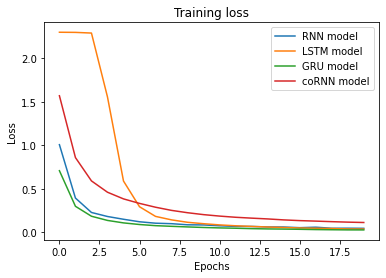

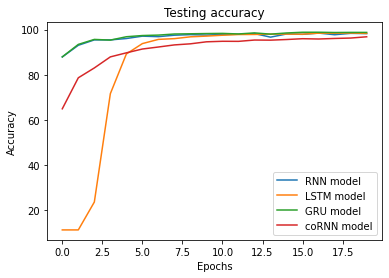

In [69]:
plt.plot(rnn_train_loss, label="RNN model")
plt.plot(lstm_train_loss, label="LSTM model")
plt.plot(gru_train_loss, label="GRU model")
plt.plot(cornn_train_loss, label="coRNN model")
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(rnn_valid_accuracy, label="RNN model")
plt.plot(lstm_valid_accuracy, label="LSTM model")
plt.plot(gru_valid_accuracy, label="GRU model")
plt.plot(cornn_valid_accuracy, label="coRNN model")
plt.title("Testing accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
